## Setup

In [1]:
#from load import load
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import torch
from torch import nn
from torchsummary import summary
import mlflow
from typing import Callable, Dict, Optional, Type, Any, List
import math
import pyro.distributions.constraints as constraints
import pyro.distributions as dist

import os

from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import ExtractSupports, SearchForExplanation
from chirho.indexed.ops import IndexSet, gather
from chirho.observational.handlers import condition
from chirho.interventional.handlers import do
from chirho.observational.handlers.soft_conditioning import soft_eq, KernelSoftConditionReparam

from chirho.dynamical.handlers import (
    DynamicIntervention,
    LogTrajectory,
    StaticBatchObservation,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate

# import importlib
# from chirho.explainable.handlers import explanation
# importlib.reload(explanation)
# from chirho.explainable.handlers.explanation import SearchForExplanation

# import pyro
# import pyro.distributions as dist
# from chirho.interventional.handlers import do

# from chirho.observational.handlers import condition
from chirho.observational.handlers.predictive import PredictiveModel

import pyro

from pyro.infer import Predictive
from pyro.infer.autoguide import AutoGuide, AutoMultivariateNormal, init_to_mean

from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports
import matplotlib

from mpl_toolkits.axes_grid1 import make_axes_locatable


from torch.distributions.utils import broadcast_all
from collections import OrderedDict

smoke_test = "CI" in os.environ


num_samples = 100 if not smoke_test else 30
num_steps = 300 if not smoke_test else 10
epochs = 300 if not smoke_test else 10


device = "cuda" if torch.cuda.is_available() else "cpu"

#mlflow.set_tracking_uri("file:../../mlruns")


## Fishery model

/tmp/ipykernel_45533/246495209.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


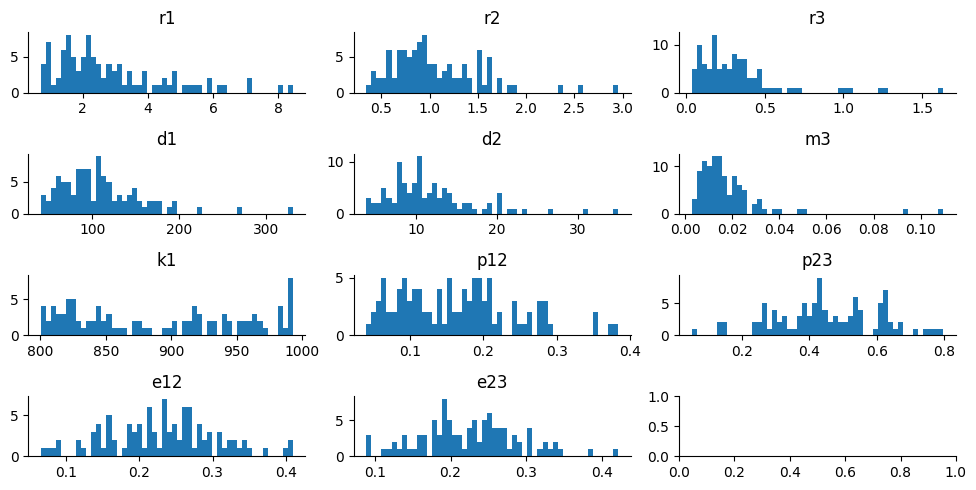

In [2]:
loc_scale_for_prior = OrderedDict(
    r1=dict(loc=0.76, scale=0.59),
    r2=dict(loc=0.0, scale=0.42),
    r3=dict(loc=-1.3, scale=0.79),
    d1=dict(loc=4.61, scale=0.42),
    d2=dict(loc=2.30, scale=0.42),
    m3=dict(loc=-4.232, scale=0.6)
)

def sample_fishery_priors():
    sampled =  {
        key: pyro.sample(key, dist.LogNormal(value["loc"], value["scale"]))
        for key, value in loc_scale_for_prior.items()
    }

    sampled['k1'] = pyro.sample('k1', dist.Uniform(800, 1000.))
    sampled['p12'] = pyro.sample('p12', dist.Beta(3., 6.))/2
    sampled['p23'] = pyro.sample('p23', dist.Beta(4., 5.))
    sampled['e12'] = pyro.sample('e12', dist.Beta(5., 6.))/2
    sampled['e23'] = pyro.sample('e23', dist.Beta(5., 6.))/2

    return sampled

with pyro.plate("prior", num_samples):
    param_samples = sample_fishery_priors()


fig, ax = plt.subplots(4, 3, figsize=(10, 5))
ax = ax.flatten()

i = 0 
for key, value in param_samples.items():
    ax[i].hist(value.detach().numpy(), bins=50)
    ax[i].set_title(key)
    i += 1
   
sns.despine()
fig.tight_layout()
fig.show()


In [3]:
param_sample_medians = {
    key: value.median()
    for key, value in param_samples.items()
}

INITIAL_STATE_no_pressure = {
    "forage": torch.tensor(1000),
    "intermediate": torch.tensor(150),
    "apex": torch.tensor(30),
    'catch_intermediate': torch.tensor(0.0),
    'fishing_effort_forage': torch.tensor(0.0),
    'fishing_effort_intermediate': torch.tensor(0),
    'fishing_effort_apex': torch.tensor(0.0),
}



INITIAL_STATE_pressure = {
    "forage": torch.tensor(1000),
    "intermediate": torch.tensor(150),
    "apex": torch.tensor(30),
    'catch_intermediate': torch.tensor(0.0),
    'fishing_effort_forage': torch.tensor(0.0),
    'fishing_effort_intermediate': torch.tensor(0.7),
    'fishing_effort_apex': torch.tensor(0.07),
}

def add_postfix_to_dict(d, postfix):
    return {f"{k}_{postfix}": v for k, v in d.items()}

INITIAL_STATE_NO_PRESSURE = add_postfix_to_dict(INITIAL_STATE_no_pressure, "no_pressure")
INITIAL_STATE_PRESSURE = add_postfix_to_dict(INITIAL_STATE_pressure, "pressure")
INITIAL_STATE_DEPENDENT = add_postfix_to_dict(INITIAL_STATE_pressure, "dependent")

In [4]:

class FishDynamics(pyro.nn.PyroModule):
    def __init__(self, params: Dict = param_sample_medians, postfix: str = ""):
        super().__init__()
        self.params = params
        self.postfix = postfix
    

    @staticmethod
    def holling_tanner(B: torch.Tensor, r: torch.Tensor, K: torch.Tensor, 
                    M: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        The general holling-tanner differential equation.
        This subtracts predator and fishing mortality from capacity-limited growth.
        B is the biomass for this trophic level.
        K is its carrying capacity, which may be a function of prey biomass.
        M is the mortality rate, potentially due to predation.
        F is the fishing mortality rate.
        """
        return r * B * (1 - B / K) - M * B - F * B

    @staticmethod
    def mortality_from_predation(B: torch.Tensor, B_pred: torch.Tensor, 
                                p: torch.Tensor, D: torch.Tensor) -> torch.Tensor:
        """
        Mortality rate of prey due to predation.
        This plugs in as M above for prey species with biomass B.
        p is the maximum rate of predation.
        B is the biomass of the prey, and B_pred is the biomass of the predator.
        D is the biomass when the predation rate reaches half of its maximum.
        """
        return (p * B_pred) / (D + B)

    @staticmethod
    def carrying_capacity_of_predator(B_prey: torch.Tensor, e: torch.Tensor) -> torch.Tensor:
        """
        Carrying capacity of the predator — this plugs in as K above for predator species.
        e is the proportion of prey biomass that is converted into predator biomass.
        """
        return B_prey * e

    @staticmethod
    def intermediate_trophic_level(B: torch.Tensor, r: torch.Tensor, B_prey: torch.Tensor, 
                                e: torch.Tensor, B_pred: torch.Tensor, p: torch.Tensor, 
                                D: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        Equation for intermediate trophic levels that are both prey and predator.
        """
        K = FishDynamics.carrying_capacity_of_predator(B_prey, e)
        M = FishDynamics.mortality_from_predation(B, B_pred, p, D)
        return FishDynamics.holling_tanner(B, r, K, M, F)

    @staticmethod
    def apex_trophic_level(B: torch.Tensor, r: torch.Tensor, B_prey: torch.Tensor, 
                        e: torch.Tensor, M: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        The top trophic level that has some constant natural mortality rate.
        """
        
        K = FishDynamics.carrying_capacity_of_predator(B_prey, e)
       
        return FishDynamics.holling_tanner(B, r, K, M, F)

    @staticmethod
    def forage_trophic_level(B: torch.Tensor, r: torch.Tensor, K: torch.Tensor, 
                            B_pred: torch.Tensor, p: torch.Tensor, D: torch.Tensor, 
                            F: torch.Tensor) -> torch.Tensor:
        """
        The bottom trophic level that has some constant carrying capacity
        """

        M = FishDynamics.mortality_from_predation(B, B_pred, p, D)
        return FishDynamics.holling_tanner(B, r, K, M, F)

    def forward(self, X: State[torch.Tensor]) -> State[torch.Tensor]:
        r1, r2, r3, d1, d2, m3, k1, p12, p23, e12, e23 = self.params.values()
        postfix = self.postfix  
  
        dX = dict()
        dX[f"forage_{postfix}"] = FishDynamics.forage_trophic_level(
            X[f"forage_{postfix}"], r1, k1, X[f"intermediate_{postfix}"], p12, d1, X[f"fishing_effort_forage_{postfix}"]
        )


        dX[f"intermediate_{postfix}"] = FishDynamics.intermediate_trophic_level(
            B = X[f"intermediate_{postfix}"], 
            r = r2, 
            B_prey = X[f"forage_{postfix}"],
            e =  e12,
            B_pred = X[f"apex_{postfix}"],
            p =  p23, 
            D = d2,
            F = X[f"fishing_effort_intermediate_{postfix}"]
        )


        dX[f"apex_{postfix}"] = FishDynamics.apex_trophic_level(
            B = X[f"apex_{postfix}"], 
            r = r3, 
            B_prey = X[f"intermediate_{postfix}"],
            e = e23, 
            M = m3, 
            F = X[f"fishing_effort_apex_{postfix}"]
        )

        dX[f'catch_intermediate_{postfix}'] = X[f'fishing_effort_intermediate_{postfix}'] * X[f'intermediate_{postfix}']
     

        dX[f'fishing_effort_forage_{postfix}'] = torch.tensor(0.)
        dX[f'fishing_effort_intermediate_{postfix}'] = torch.tensor(0.)
        dX[f'fishing_effort_apex_{postfix}'] = torch.tensor(0.)

        return(dX)


## Trajectiories under full fishing/no fishing regimes

In [5]:
fish_dynamics_pressure = FishDynamics(postfix = "pressure")
fish_dynamics_no_pressure = FishDynamics(postfix = "no_pressure")

start_time = torch.tensor(0.0)
end_time = torch.tensor(0.52)
step_size = torch.tensor(0.01)
logging_times = torch.arange(start_time, end_time, step_size)


with TorchDiffEq(), LogTrajectory(logging_times) as lt_no_pressure:
    simulate(fish_dynamics_no_pressure, INITIAL_STATE_NO_PRESSURE, start_time, end_time,)

trajectory_no_pressure = lt_no_pressure.trajectory

with TorchDiffEq(), LogTrajectory(logging_times) as lt_pressure:
    simulate(fish_dynamics_pressure, INITIAL_STATE_PRESSURE, start_time, end_time)
trajectory_pressure = lt_pressure.trajectory

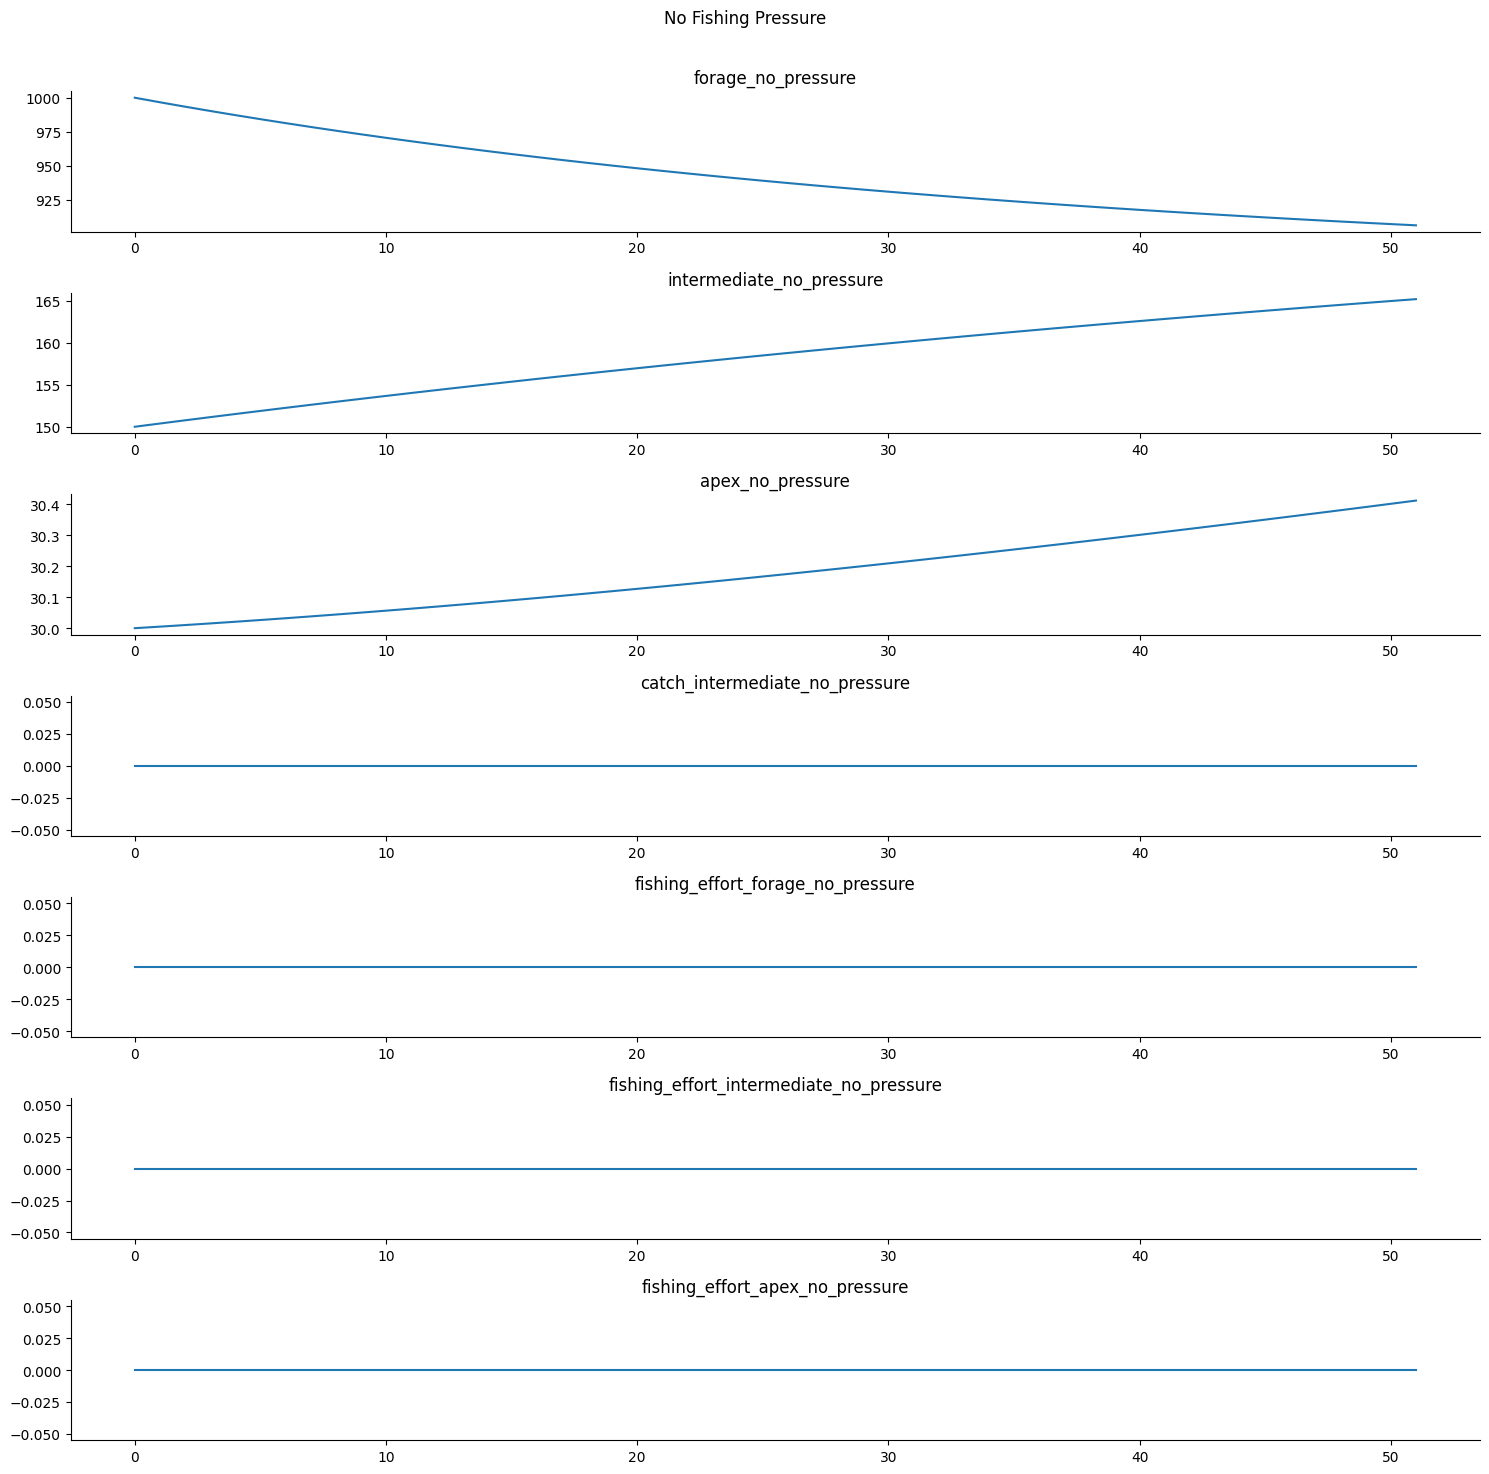

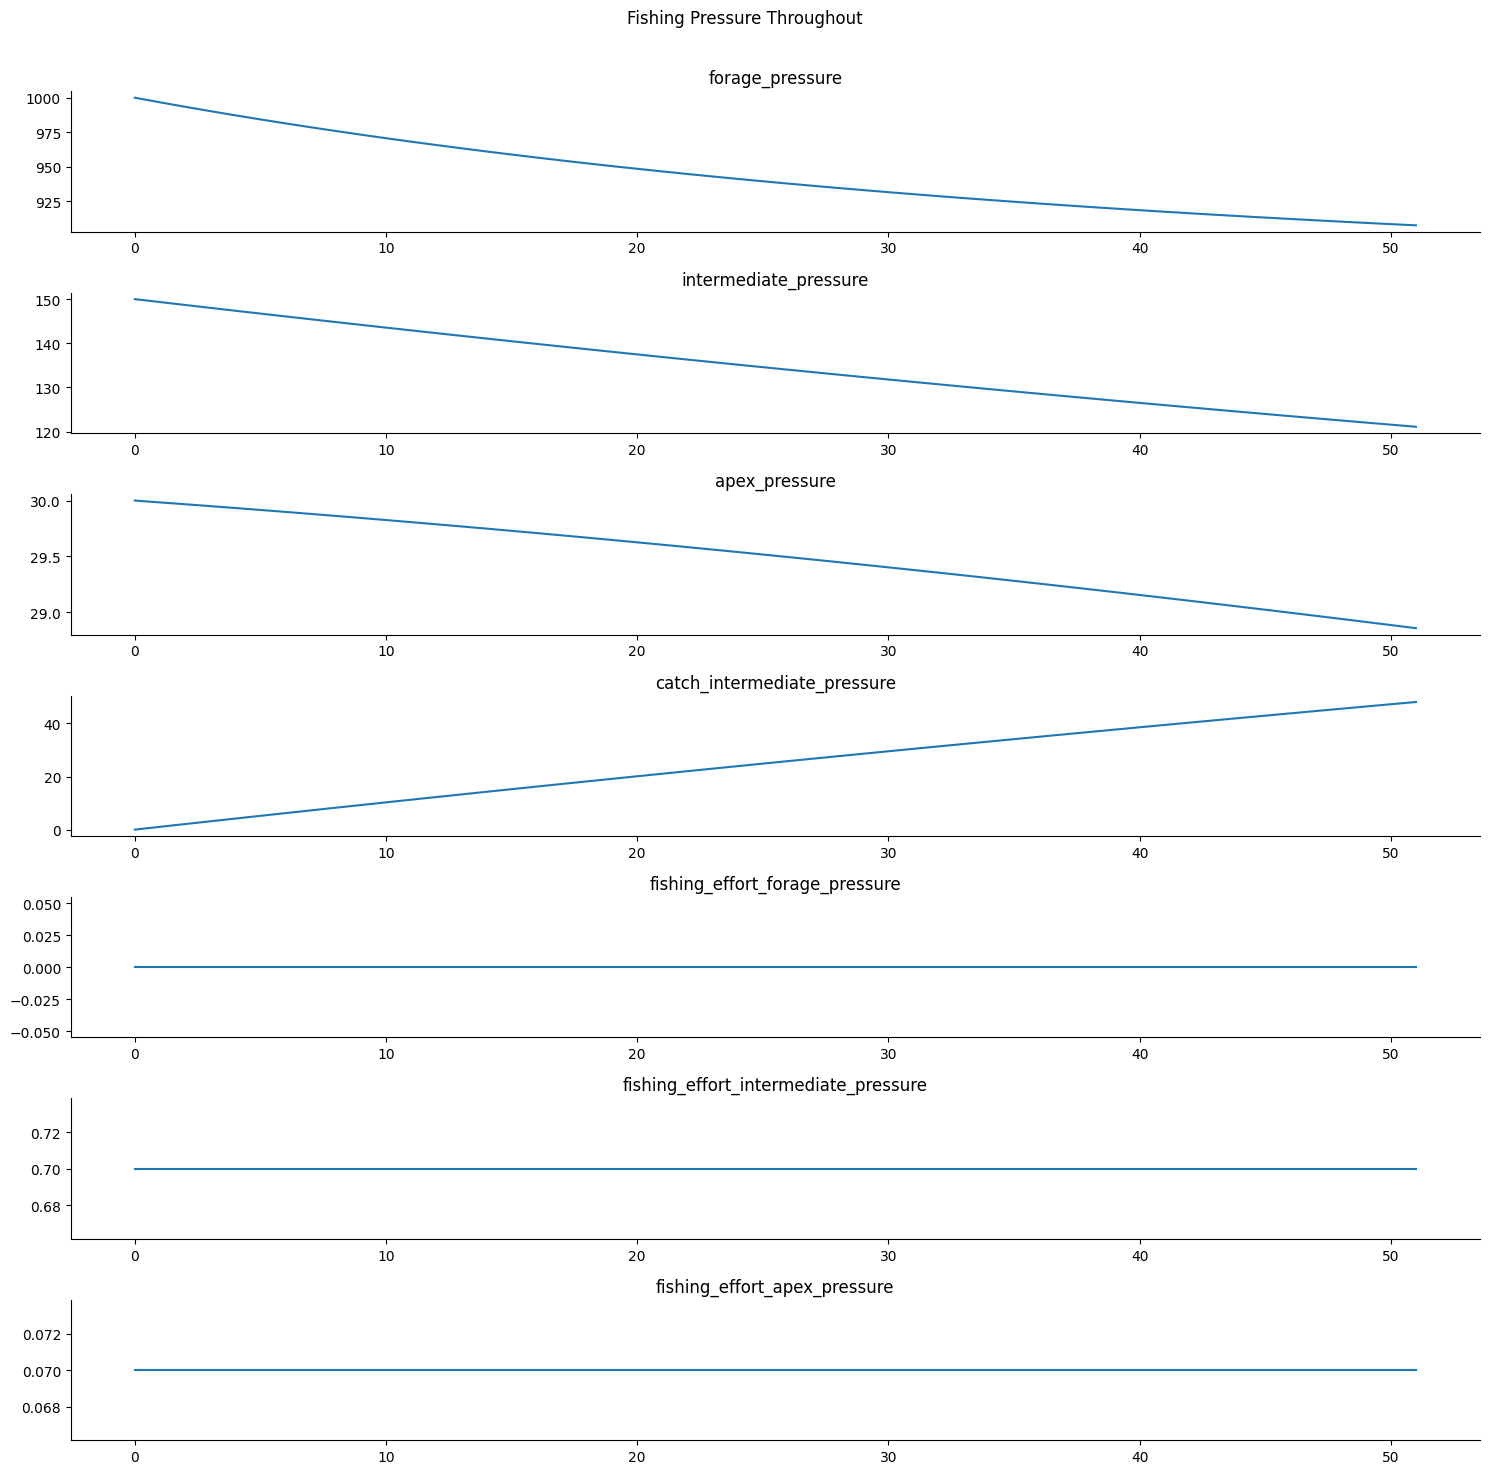

In [6]:
def plot_trajectories(trajectories, title):
    fig, ax = plt.subplots(7, 1, figsize=(15, 15))

    for i, key in enumerate(trajectories.keys()):
        ax[i].plot(trajectories[key], label=key)
        ax[i].set_title(key)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    sns.despine()
    plt.suptitle(title)
    plt.show()


plot_trajectories(trajectory_no_pressure, "No Fishing Pressure")
plot_trajectories(trajectory_pressure, "Fishing Pressure Throughout")

## Incorporate uncertainty about model parameters

In [7]:
def stop_fishing_policy(target_state: State[torch.tensor], postfix: str = "dependent"):
    """
    The event function for the stop fishing policy. This is a function
    that passes zero when the catch of the intermediate fish passes a quota
    specified by `target_state`.
    """
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return  state[f"catch_intermediate_{postfix}"] - target_state[f"catch_intermediate_{postfix}"]
    return event_f


In [57]:
quota = {'catch_intermediate_dependent': torch.tensor(25.)}
season_ends = {key: torch.tensor(0.) for key in INITIAL_STATE_DEPENDENT.keys() if key.startswith('fishing_effort')}
# NOTICE: no warning if the intervention key is not in the state!! (eg. INITIAL_STATE_PRESSURE.keys())



In [60]:
torch.manual_seed(42)
pyro.set_rng_seed(42)

def bayesian_parallel_dynamics():

    shared_noise = sample_fishery_priors()

    fish_dynamics_no_pressure = FishDynamics(params = shared_noise, postfix = "no_pressure")
    fish_dynamics_pressure = FishDynamics(params = shared_noise, postfix = "pressure")
    fish_dynamics_state_dependent = FishDynamics(params = shared_noise, postfix = "dependent")

    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt_no_pressure:
        simulate(fish_dynamics_no_pressure, INITIAL_STATE_NO_PRESSURE, start_time, end_time,)

    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt_pressure:
        simulate(fish_dynamics_pressure, INITIAL_STATE_PRESSURE, start_time, end_time)

    with TorchDiffEq(),LogTrajectory(logging_times, is_traced=True) as lt_dependent:
        with DynamicIntervention(event_fn=stop_fishing_policy(quota), intervention= season_ends):
                    simulate(fish_dynamics_state_dependent, INITIAL_STATE_DEPENDENT, start_time, logging_times[-1])

fishery_predictive = Predictive(bayesian_parallel_dynamics, num_samples=num_samples)
fishery_samples =  fishery_predictive()

In [62]:
pressure_samples = {key: value for key, value in fishery_samples.items() if "pressure" in key and "no" not in key}
no_pressure_samples = {key: value for key, value in fishery_samples.items() if "no_pressure" in key}
dependent_samples = {key: value for key, value in fishery_samples.items() if "dependent" in key}

pressure_samples_medians    = {key: value.median(dim = 0).values for key, value in pressure_samples.items()}
no_pressure_samples_medians = {key: value.median(dim = 0).values for key, value in no_pressure_samples.items()}
dependent_samples_medians = {key: value.median(dim = 0).values for key, value in dependent_samples.items()}

In [63]:
def plot_trajectory_samples(pressure_samples, postfix, title, event_time = None, ):

    pressure_samples_medians = {key: value.median(dim = 0).values for key, value in pressure_samples.items()}
    pressure_samples_lows = {key: value.quantile(0.05, dim = 0) for key, value in pressure_samples.items()}
    pressure_samples_highs = {key: value.quantile(0.95, dim = 0) for key, value in pressure_samples.items()}
    
    state_keys = [f'forage_{postfix}', f'intermediate_{postfix}', f'apex_{postfix}', f'catch_intermediate_{postfix}']

    
    fig, ax = plt.subplots(len(state_keys)+1, 1, figsize=(15, 15))

    ax = ax.flatten()

    for i in range(len(state_keys)):
        key = state_keys[i]
        ax[i].plot(pressure_samples_medians[key], label=key)
        ax[i].set_title(key)
        ax[i].fill_between(
            torch.arange(pressure_samples_medians[key].shape[0]),
            pressure_samples_lows[key],
            pressure_samples_highs[key],
            alpha=0.2,
        )

        if event_time is not None:
            ax[i].axvline(event_time, color='red', linestyle='--')


    pressure = pressure_samples[f'fishing_effort_intermediate_{postfix}']

    average_pressure = False
    if pressure.dim() > 1:
        pressure_low = pressure_samples_lows[f'fishing_effort_intermediate_{postfix}']
        pressure_high = pressure_samples_highs[f'fishing_effort_intermediate_{postfix}']        
        average_pressure = True
        pressure = pressure.median(dim=0).values

    ax[len(state_keys)].plot(pressure)
    ax[len(state_keys)].set_title(f'Fishing Effort Intermediate_{postfix}')

    if average_pressure:
        ax[len(state_keys)].fill_between(
            torch.arange(pressure.shape[0]),
            pressure_low,
            pressure_high,
            alpha=0.2,
        )
    ax[len(state_keys)].set_ylim(-0.1,1)
    


    fig.tight_layout(rect=[0, 0, 1, 0.95])
    sns.despine()
    fig.suptitle(title)
    fig.show()
    plt.show()


/tmp/ipykernel_45533/3668513358.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


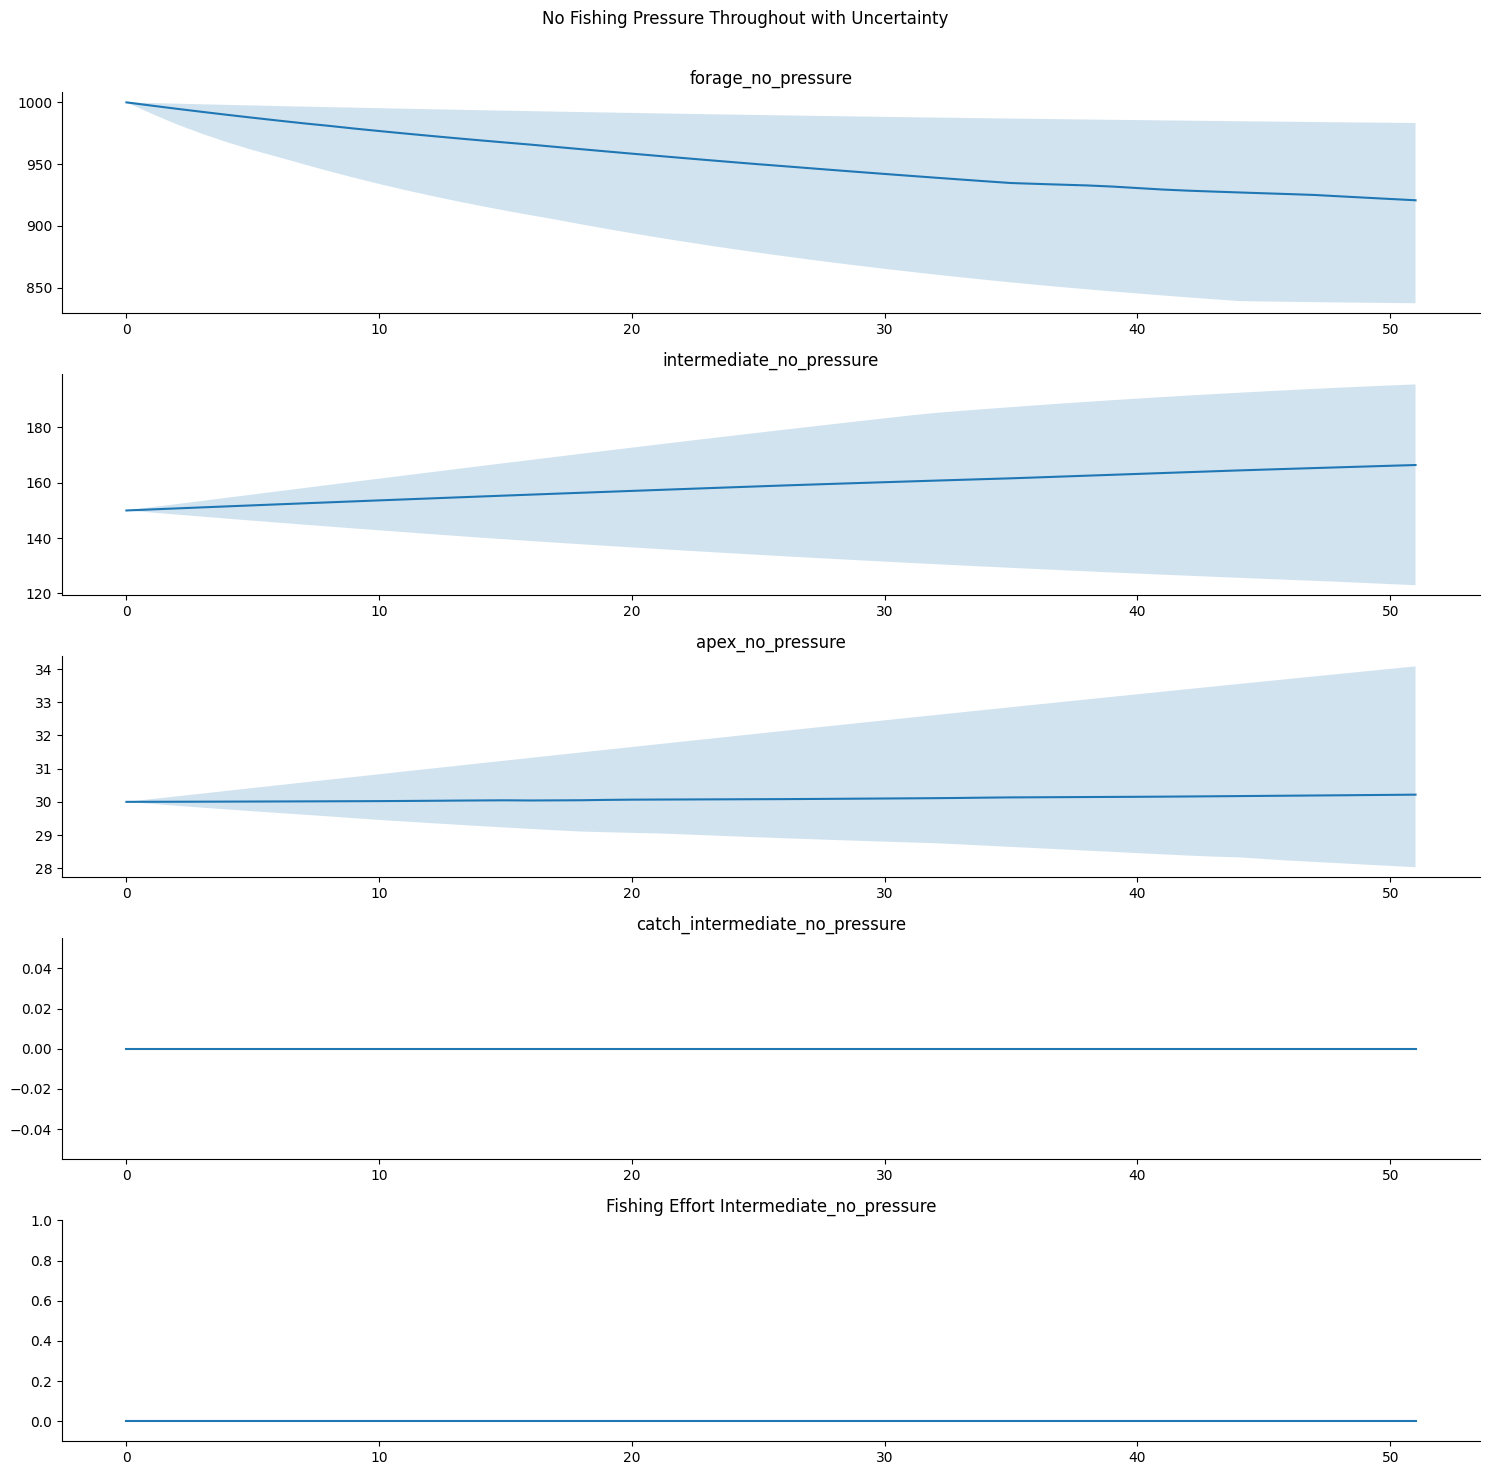

In [64]:
plot_trajectory_samples(no_pressure_samples, postfix = "no_pressure", 
title = "No Fishing Pressure Throughout with Uncertainty")


/tmp/ipykernel_45533/3668513358.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


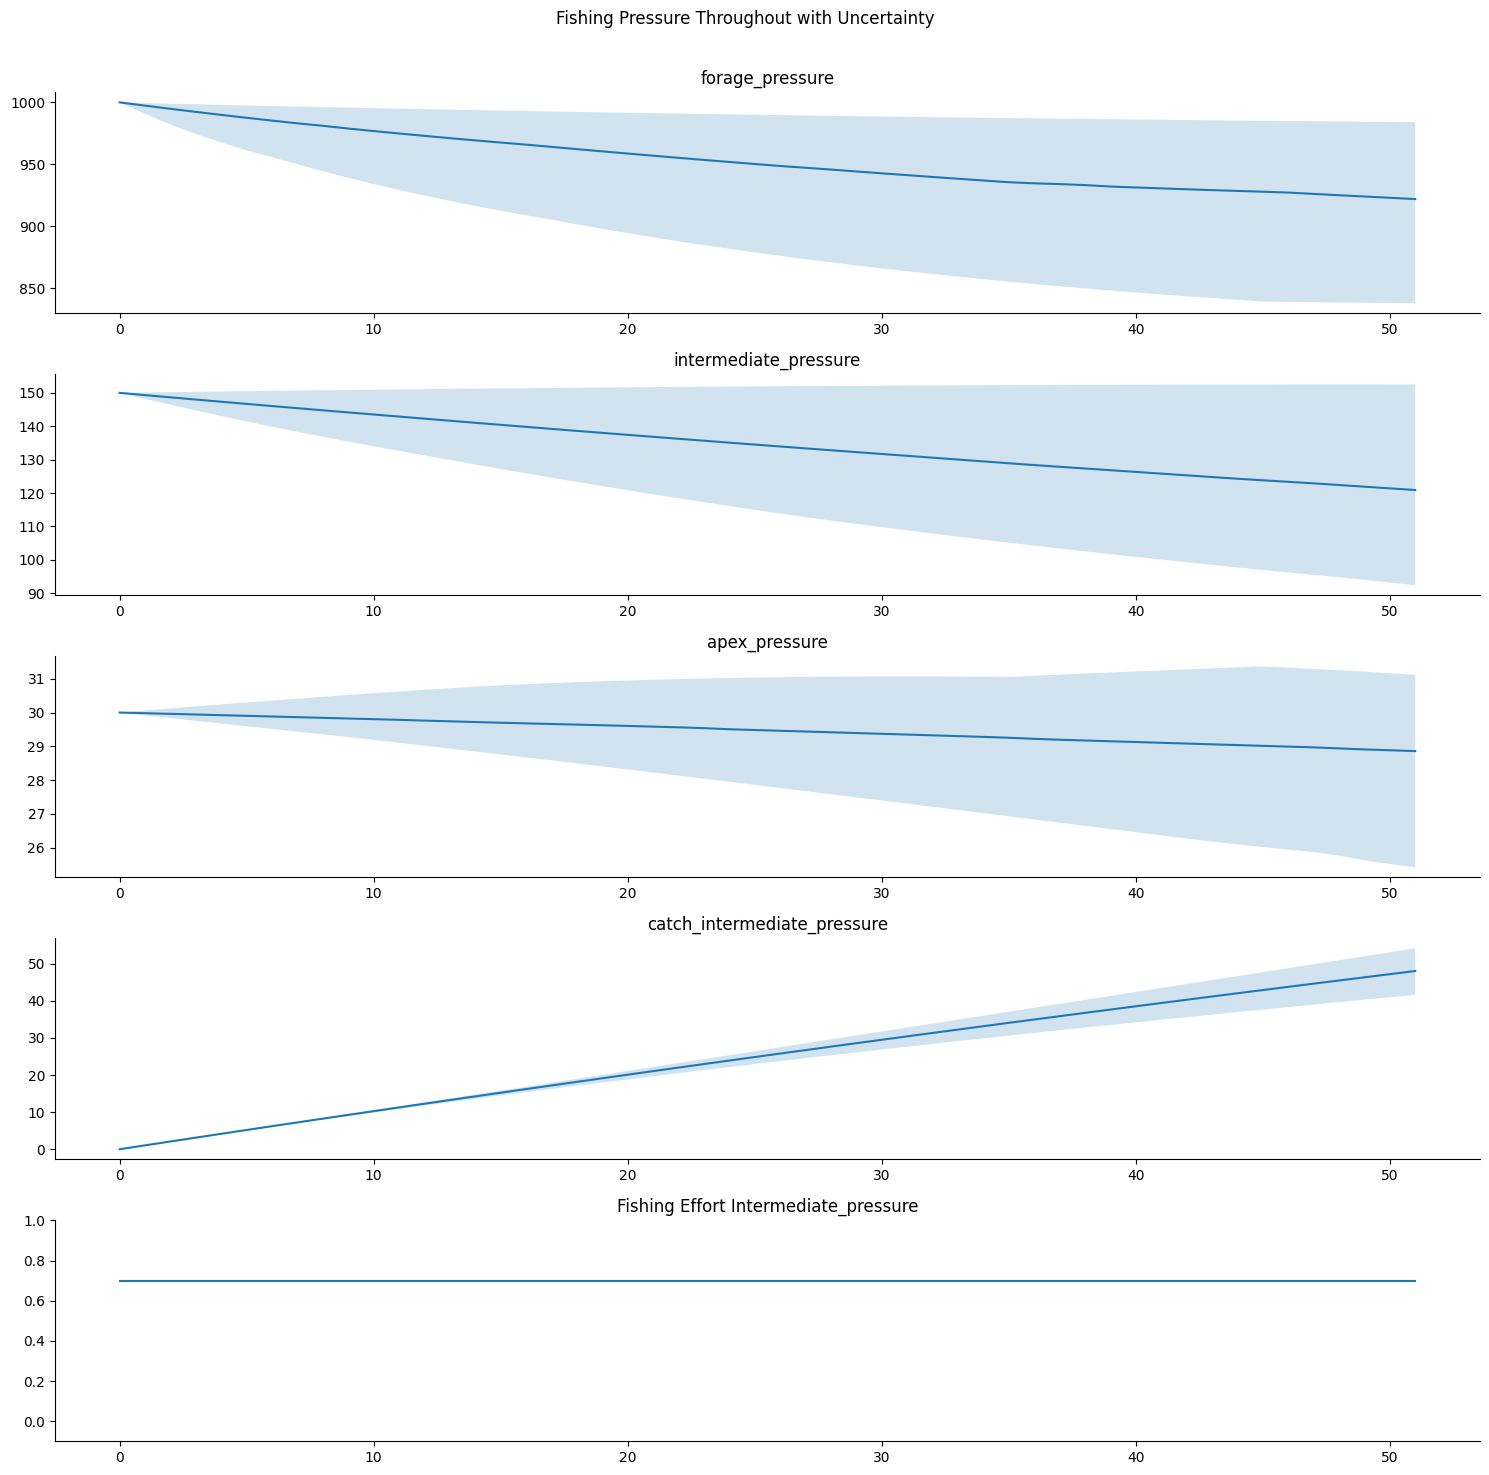

In [65]:
plot_trajectory_samples(pressure_samples, postfix = "pressure", title =  "Fishing Pressure Throughout with Uncertainty")


/tmp/ipykernel_45533/3668513358.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


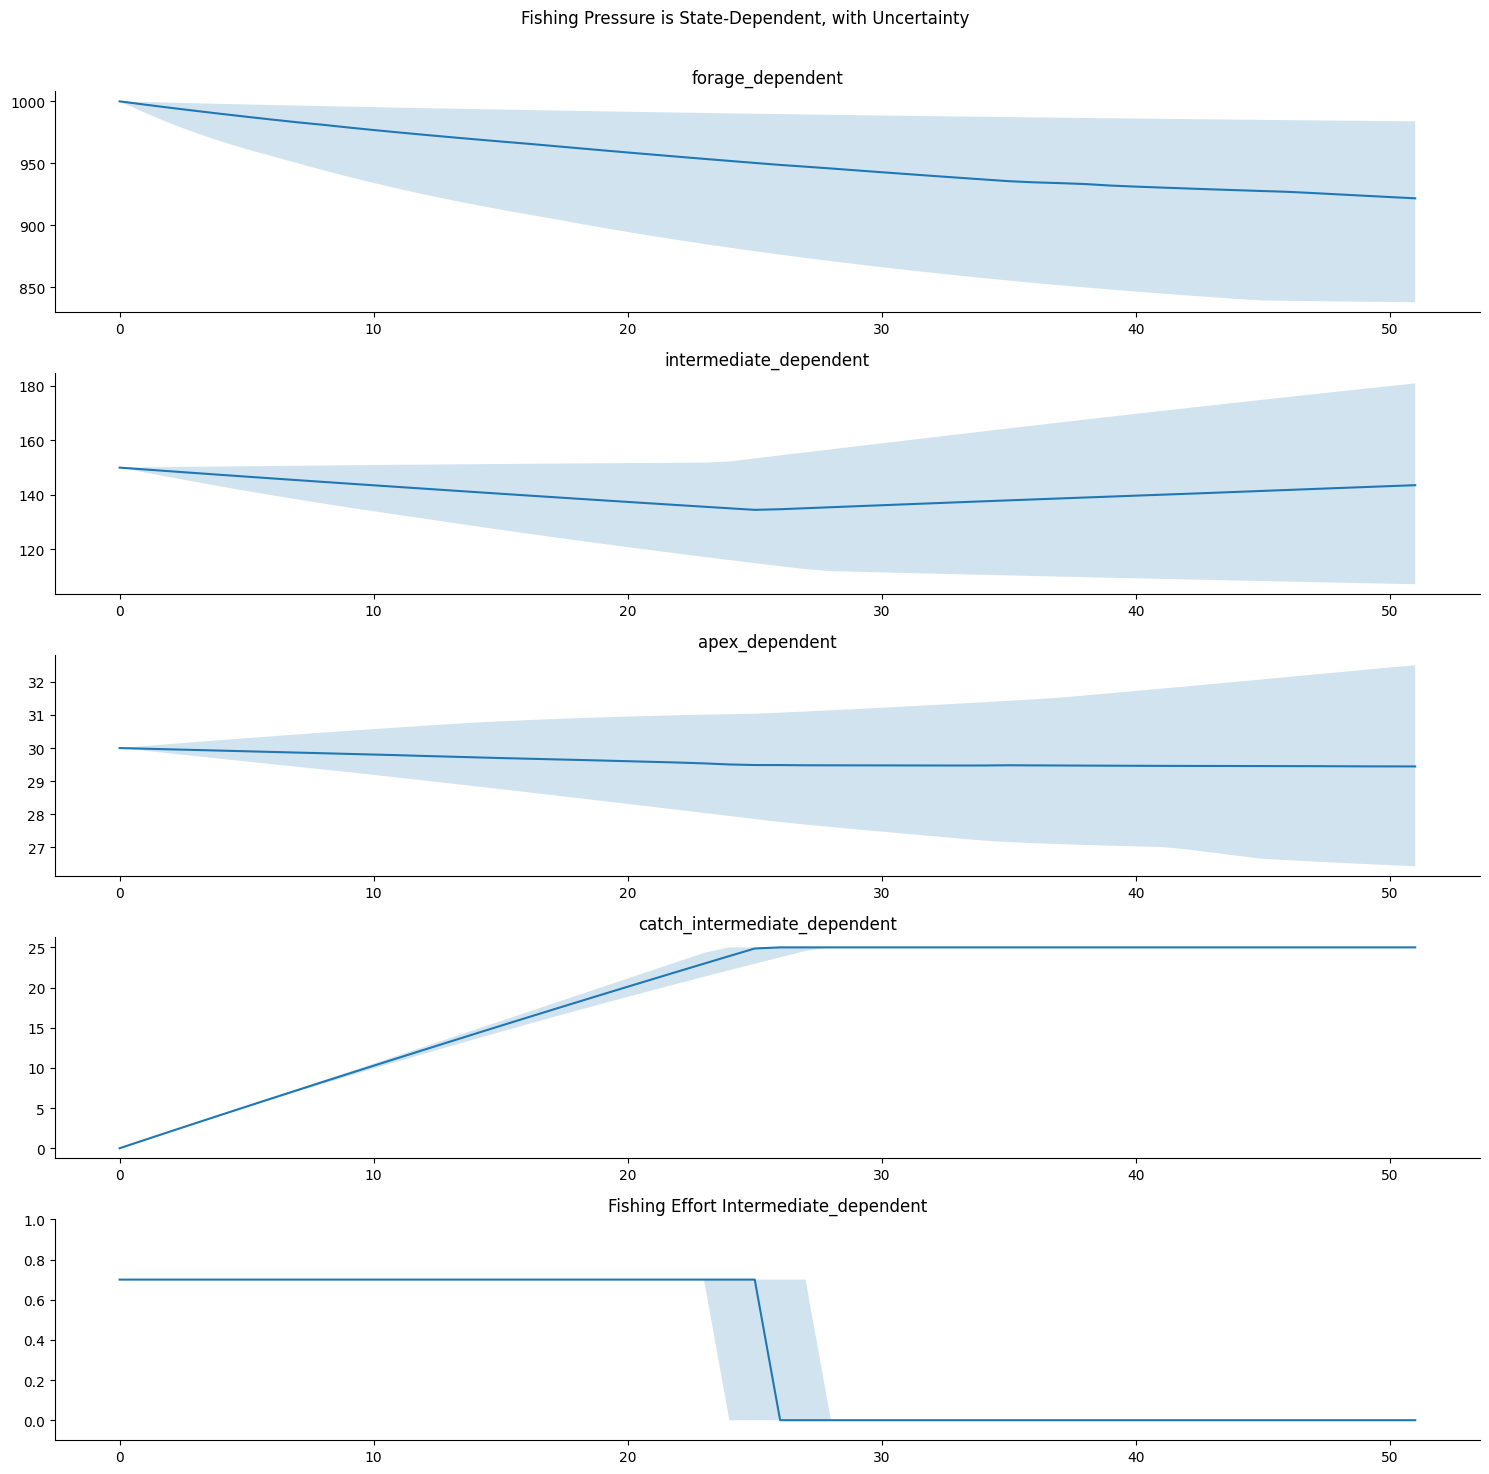

In [66]:
plot_trajectory_samples(dependent_samples, postfix = "dependent", 
title =  "Fishing Pressure is State-Dependent, with Uncertainty")


## Compare outcomes

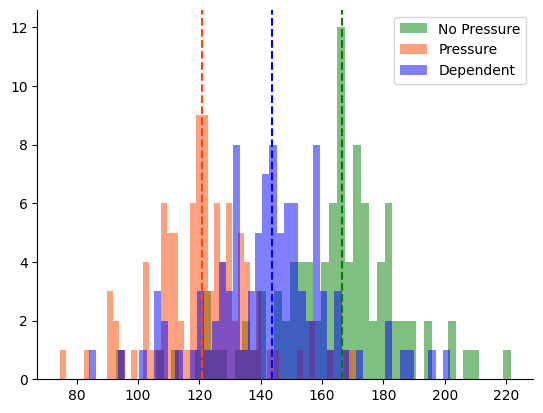

In [70]:
outcome_no_pressure = no_pressure_samples['intermediate_no_pressure'][:,-1]
outcome_pressure = pressure_samples['intermediate_pressure'][:, -1]
outcome_dependent= dependent_samples['intermediate_dependent'][:, -1]

plt.hist(outcome_no_pressure, bins=50, alpha=0.5, color = "green", label='No Pressure')
plt.axvline(outcome_no_pressure.median(), color='green', linestyle='--')

plt.hist(outcome_pressure, bins=50, alpha=0.5, color = "orangered", label='Pressure')
plt.axvline(outcome_pressure.median(), color='orangered', linestyle='--')

plt.hist(outcome_dependent, bins=50, alpha=0.5, color = "blue", label='Dependent')
plt.axvline(outcome_dependent.median(), color='blue', linestyle='--')

plt.legend()

sns.despine()
plt.show()


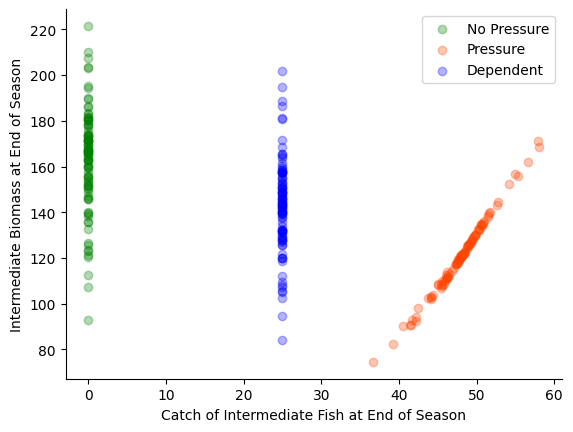

In [75]:
catch_no_pressure = no_pressure_samples['catch_intermediate_no_pressure'][:,-1]
catch_pressure = pressure_samples['catch_intermediate_pressure'][:, -1]
catch_dependent = dependent_samples['catch_intermediate_dependent'][:, -1]

plt.scatter(catch_no_pressure, outcome_no_pressure, alpha=0.3, color="green", label="No Pressure")
plt.scatter(catch_pressure, outcome_pressure, alpha=0.3, color="orangered", label="Pressure")
plt.scatter(catch_dependent, outcome_dependent, alpha=0.3, color="blue", label="Dependent")

plt.legend()
plt.xlabel("Catch of Intermediate Fish at End of Season")
plt.ylabel("Intermediate Biomass at End of Season")
sns.despine()
plt.show()


## Probability of necessity and sufficiency

In [84]:
# What's the probability of the state-dependent policy necessary and sufficient for the intermediate biomass 
# to be above a certain threshold at the end of the season?
# note this involves no conditioning by definition of probability of sufficiency and necessity

threshold = torch.tensor(130.)

((outcome_pressure < threshold).float() *  (outcome_dependent > threshold).float()).mean()

tensor(0.5200)

In [90]:
# what's the probability of necessity of that policy?
# this time, we need to condition on it being triggered (X) and on the outcome being above the threshold (Y)

mask = ((outcome_dependent > threshold).float() * (catch_dependent <= quota['catch_intermediate_dependent']).float()).bool()

# non-rejected proportion of the sample
print(mask.float().mean())

# now probability that this outcome would not appear without the intervention
(outcome_pressure[mask] < threshold).float().mean()

tensor(0.7600)


tensor(0.6711)

Two plausible questions:

Was the quota being q1 rather than q2 with q1 < q2, necessary and sufficient for the total biomass being above a certain threshold by the start of the next period of interest

## Implementations that don't work`

In [ ]:
with condition(data = param_noise):
    pressure_samples = pressure_predictive(INITIAL_STATE_PRESSURE, start_time, logging_times)


In [ ]:
def dynamic_multiworld_fishing(quota, init_state, start_time, logging_times) -> State:
    dynamics = bayesian_fish_dynamics()
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with TorchDiffEq():
            with MultiWorldCounterfactual():
                with DynamicIntervention(event_fn=stop_fishing_policy(quota), intervention= season_ends):
                    simulate(dynamics, INITIAL_STATE_PRESSURE, start_time, logging_times[-1])
    return lt.trajectory

dynamic_multiworld_predictive = Predictive(dynamic_multiworld_fishing, num_samples=num_samples)
dynamic_multiworld_samples = dynamic_multiworld_predictive(quota,  season_ends, start_time, logging_times)
